In [2]:
from dataclasses import replace
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import os.path
import sys
import logging
import pickle
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from models.garnet_trigger import GNNGraphClassifier
from icecream import ic
from numpy.linalg import inv
import sklearn.metrics as metrics
from datasets import get_data_loaders
from tqdm.notebook import tqdm

In [3]:
DEVICE = "cuda:0"

In [4]:
# create model and load checkpoint
#model_result_folder = '/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger_results/agnn/agnn-lr8.19806576478371e-05-b12-d71-PReLU-gi1-ln-True-n1600000/experiment_2024-04-26_13:41:37'
#MLP Trigger Layerwise
#model_result_folder = '/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger_results/agnn/agnn-lr0.0002049399893487043-b12-d9-ReLU-gi1-ln-True-n1600000/experiment_2024-05-28_09:13:00'
model_result_folder = '../trigger_results/agnn/agnn-lr0.00014116174333685284-b64-d64-PReLU-gi1-ln-True-n80000/experiment_2024-11-27_21:56:42/'
config_file = model_result_folder + '/config.pkl'
config = pickle.load(open(config_file, 'rb'))
data_config = config.get('data')
dphi_max, dz_max = data_config['phi_slope_max'], data_config['z0_max']

model_config = config.get('model', {})
model_config.pop('loss_func')
model_config.pop('name')
model = GNNGraphClassifier(**model_config).to(DEVICE)

def load_checkpoint(checkpoint_file, model, optimizer=None):
    checkpoint = torch.load(checkpoint_file, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model'])
    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer'])
        return model, optimizer
    return model

# load_checkpoint
checkpoint_dir = os.path.join(model_result_folder, 'checkpoints')
checkpoint_file = sorted([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('model_checkpoint')])
checkpoint_file = checkpoint_file[-1]
print(checkpoint_file)
model = load_checkpoint(checkpoint_file, model)
print('Successfully reloaded!')

../trigger_results/agnn/agnn-lr0.00014116174333685284-b64-d64-PReLU-gi1-ln-True-n80000/experiment_2024-11-27_21:56:42/checkpoints/model_checkpoint_011.pth.tar
Successfully reloaded!


/tmp/ipykernel_2471244/1996625541.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file, map_location=torch.device('cpu'))


In [4]:
data_config['input_dir2']

'/ssd2/giorgian/hits-data-august-2022/nontrigger/0/'

In [5]:
data_config

{'batch_size': 12,
 'construct_edges': False,
 'input_dir': '/ssd3/giorgian/hits-data-march-2024/trigger/1/',
 'input_dir2': '/ssd2/giorgian/hits-data-august-2022/nontrigger/0/',
 'load_full_event': False,
 'n_folders': 2,
 'n_mix': 10,
 'n_train': 800000,
 'n_valid': 175000,
 'n_workers': 16,
 'name': 'hit_graph_trigger_pileup',
 'phi_slope_max': 0.012193355583173944,
 'real_weight': 1,
 'z0_max': 14.220353082111805}

In [10]:
dconfig = config['data']
#dconfig['trigger_input_dir'] = '/ssd3/giorgian/hits-data-march-2024/trigger/1/'
dconfig['n_valid'] += dconfig['n_train'] 
dconfig['n_train'] = 1

In [5]:
train_data_loader, valid_data_loader = get_data_loaders(distributed=False, rank=0, n_ranks=0, **data_config)


In [6]:
preds, targets = [], []
sigmoid = torch.nn.Sigmoid()
model.eval()
for batch in tqdm(valid_data_loader):
    preds.extend(model(batch.to(DEVICE)).squeeze(0).detach().cpu().numpy())
    targets.extend(batch.trigger.squeeze(0).detach().cpu().numpy())

  0%|          | 0/313 [00:00<?, ?it/s]

/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/tracking-GNN/models/garnet_trigger.py:127: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789560443/work/torch/csrc/tensor/python_tensor.cpp:78.)
  temp = torch.cuda.FloatTensor(x.shape[0]).fill_(1)


In [7]:
def efficiency_purity(correct, preds_prob, signal_mix=0.01):
    signal = np.where(correct)[0]
    background = np.where(1 - correct)[0]
    mix = len(signal)/len(correct)
    drop = int(np.ceil((len(signal) - signal_mix * len(correct))/(1 - signal_mix)))
    np.random.shuffle(signal)
    keep = signal[:len(signal) - drop]
    keep = np.concatenate([keep, background], axis=0)
    c = correct[keep]
    p = preds_prob[keep]
    # Calculate efficiency
    tp = np.sum(c * (p > 0.5))
    tn = np.sum(( 1- c) * (p <= 0.5))
    fp = np.sum((1 - c) * (p > 0.5))
    fn = np.sum(c * (p <= 0.5))

    # effiency is how much of the signal we captured
    efficiency = tp/(tp + fn)
    # purity is how much of the signal is true
    purity = tp/(tp + fp)
    brr = tn/(tn + fp)

    return efficiency, purity, brr

def efficiency_purity_2(correct, preds_prob, signal_mix=0.01):
    signal = np.where(correct)[0]
    background = np.where(1 - correct)[0]
    mix = len(signal)/len(correct)
    drop = int(np.ceil((len(signal) - signal_mix * len(correct))/(1 - signal_mix)))

    np.random.shuffle(signal)
    keep = signal[:len(signal) - drop]
    keep = np.concatenate([keep, background], axis=0)
    c = correct[keep]
    print(f'{np.sum(c)/c.shape[0]=}')
    p = preds_prob[keep]
    # Calculate efficiency
    cutoffs = np.unique(p)
    efficiencies = []
    purities = []
    brrs = []
    for cutoff in tqdm(cutoffs):
        tp = np.sum(c * (p > cutoff))
        tn = np.sum(( 1- c) * (p <= cutoff))
        fp = np.sum((1 - c) * (p > cutoff))
        fn = np.sum(c * (p <= cutoff))

        # effiency is how much of the signal we captured
        efficiency = tp/(tp + fn) if tp + fp != 0 else 0
        # purity is how much of the signal is true
        purity = tp/(tp + fp) if tp + fp != 0 else 1
        brr = tn / (tn + fp) if tn + fp != 0 else 0

        efficiencies.append(efficiency)
        purities.append(purity)
        brrs.append(brr)
        
    return np.array(efficiencies), np.array(purities), np.array(brrs)

In [8]:
preds_prob = np.array(preds)
targets = np.array(targets)

In [9]:
accs_gt = np.sum((preds_prob > 0) == targets, axis=-1)/targets.shape[0]
accs_gt

np.float64(0.9687)

In [10]:
efficiencies, purities, brrs = efficiency_purity_2(targets, preds_prob, signal_mix=0.01)

np.sum(c)/c.shape[0]=np.float64(0.009933123524783635)


  0%|          | 0/9865 [00:00<?, ?it/s]

In [20]:
for brr in [0.9, 0.95, 0.99, 0.999]:
    i = np.argmin(np.abs(brrs - brr))
    print(f'Efficiency: {efficiencies[i]*100:.4f}, Purity: {purities[i]*100:.4f}% BRR: {brrs[i]*100:.4f}%')

Efficiency: 100.0000, Purity: 9.1155% BRR: 89.9970%
Efficiency: 99.0099, Purity: 16.5837% BRR: 95.0035%
Efficiency: 94.0594, Purity: 48.4694% BRR: 98.9967%
Efficiency: 66.3366, Purity: 87.0130% BRR: 99.9007%


In [21]:
efficiencies_1, purities_1, brrs_1 = efficiency_purity_2(targets, preds_prob, signal_mix=0.005)

np.sum(c)/c.shape[0]=np.float64(0.004942176534545814)


  0%|          | 0/9814 [00:00<?, ?it/s]

In [22]:
for brr in [0.9, 0.95, 0.99, 0.999]:
    i = np.argmin(np.abs(brrs_1 - brr))
    print(f'Efficiency: {efficiencies_1[i]*100:.4f}, Purity: {purities_1[i]*100:.4f}% BRR: {brrs_1[i]*100:.4f}%')

Efficiency: 98.0000, Purity: 4.6402% BRR: 89.9970%
Efficiency: 96.0000, Purity: 8.7114% BRR: 95.0035%
Efficiency: 92.0000, Purity: 31.2925% BRR: 98.9967%
Efficiency: 54.0000, Purity: 72.9730% BRR: 99.9007%


In [23]:
efficiencies[i]*100, purities[i]*100

(np.float64(71.28712871287128), np.float64(81.81818181818183))

In [24]:
i = np.argmin(np.abs(brrs_1-0.99))

In [25]:
efficiencies_1[i]*100, purities_1[i]*100

(np.float64(92.0), np.float64(31.292517006802722))

Text(0.5, 1.0, 'Hits Efficiency/Purity Plot')

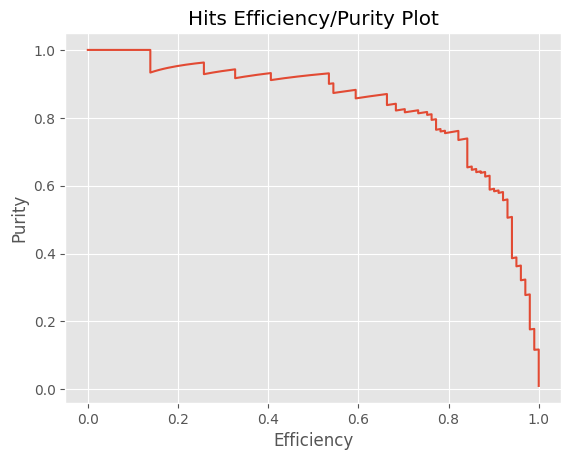

In [26]:
plt.style.use('ggplot')
plt.plot(efficiencies, purities)
plt.xlabel('Efficiency')
plt.ylabel('Purity')
plt.title('Hits Efficiency/Purity Plot')

Text(0.5, 1.0, 'Hits Efficiency/BRR Plot')

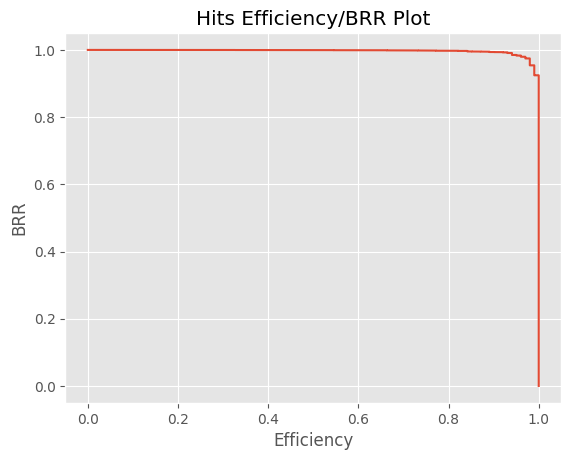

In [27]:
plt.style.use('ggplot')
plt.plot(efficiencies, brrs)
plt.xlabel('Efficiency')
plt.ylabel('BRR')
plt.title('Hits Efficiency/BRR Plot')

/tmp/ipykernel_2471244/1925746027.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(efficiencies, 1/(1 - brrs))


99.01%	16.58%	95.00%
66.34%	87.01%	99.90%


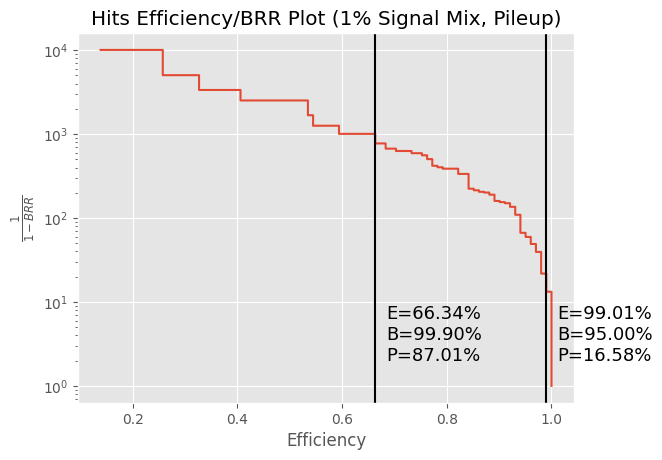

In [33]:
plt.style.use('ggplot')
plt.plot(efficiencies, 1/(1 - brrs))
plt.xlabel('Efficiency')
plt.ylabel('$\\frac{1}{1 - BRR}$')
plt.title('Hits Efficiency/BRR Plot (1% Signal Mix, Pileup)')
for brr in [0.95, 0.999]:
    i = np.argmin(np.abs(brrs - brr))
    x, y, p = efficiencies[i], brrs[i], purities[i]
    plt.axvline(x, color='black')
    plt.text(x+0.02, 2, f'E={x*100:.2f}%\nB={y*100:.2f}%\nP={p*100:.2f}%', fontsize=13)
    #plt.text(x, 0.1, f'=({x:.2f}, {y:.2f})', ha='right', va='bottom', fontsize=7)
    #plt.text(x, y, f'({x:.2f}, {y:.2f})', ha='right', va='bottom')
    print(f'{efficiencies[i]*100:.2f}%\t{purities[i]*100:.2f}%\t{brrs[i]*100:.2f}%')
plt.yscale('log')

/tmp/ipykernel_1433164/812852551.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(efficiencies_1, 1/(1 - brrs_1))


99.60%	9.14%	90.00%
54.65%	84.66%	99.90%


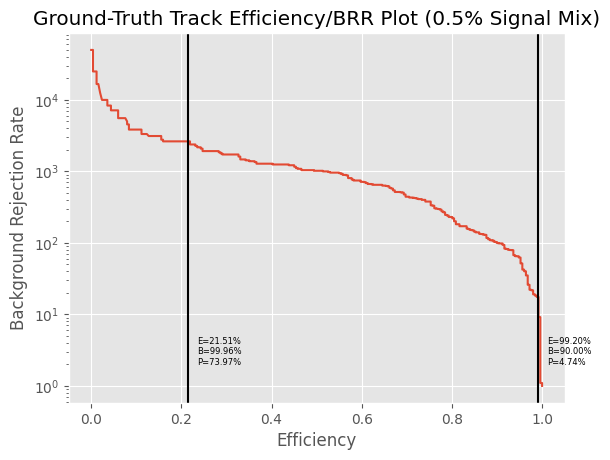

In [38]:
plt.style.use('ggplot')
plt.plot(efficiencies_1, 1/(1 - brrs_1))
plt.xlabel('Efficiency')
plt.ylabel('Background Rejection Rate')
plt.title('Ground-Truth Track Efficiency/BRR Plot (0.5% Signal Mix)')
for brr in [0.9, 0.999]:
    i = np.argmin(np.abs(brrs - brr))
    x, y, p = efficiencies_1[i], brrs_1[i], purities_1[i]
    plt.axvline(x, color='black')
    plt.text(x+0.02, 2, f'E={x*100:.2f}%\nB={y*100:.2f}%\nP={p*100:.2f}%', fontsize=6)
    #plt.text(x, 0.1, f'=({x:.2f}, {y:.2f})', ha='right', va='bottom', fontsize=7)
    #plt.text(x, y, f'({x:.2f}, {y:.2f})', ha='right', va='bottom')
    print(f'{efficiencies[i]*100:.2f}%\t{purities[i]*100:.2f}%\t{brrs[i]*100:.2f}%')
    
plt.yscale('log')

In [60]:
purities

array([0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615])

In [26]:
accs_pred_phi, accs_gt_phi

(array([0.86396484, 0.8625    , 0.86191406, 0.86191406, 0.85991211,
        0.86025391, 0.85908203, 0.85795898, 0.85771484, 0.85859375,
        0.85810547, 0.8574707 , 0.85649414, 0.85615234, 0.85541992,
        0.85595703, 0.85668945, 0.85678711, 0.85791016, 0.85888672,
        0.85869141, 0.85932617, 0.85927734, 0.85932617, 0.85854492,
        0.86015625, 0.85932617, 0.859375  , 0.85874023, 0.85849609,
        0.85927734, 0.85991211, 0.85961914, 0.86005859, 0.86015625,
        0.8609375 , 0.86079102, 0.86201172, 0.86254883, 0.86396484]),
 array([0.90356445, 0.90332031, 0.9034668 , 0.9019043 , 0.90019531,
        0.89829102, 0.89462891, 0.88847656, 0.878125  , 0.86557617,
        0.86103516, 0.87241211, 0.88481445, 0.89287109, 0.89785156,
        0.90019531, 0.90219727, 0.90219727, 0.9027832 , 0.90234375,
        0.9027832 , 0.9027832 , 0.90288086, 0.90239258, 0.90117187,
        0.89916992, 0.89375   , 0.88457031, 0.87290039, 0.86347656,
        0.86801758, 0.88217773, 0.89287109, 0.

In [ ]:
plt.plot(np.linspace(0, 2*np.pi, 40), accs_gt)
x_ticks = np.arange(0, (2 + 1/2)*np.pi, np.pi/2)
print(x_ticks)
ax = plt.gca()  # Get the current axis
ax.set_xticks(x_ticks)
ax.set_xticklabels(["0", "$\\frac{π}{2}$", "π", "$\\frac{3π}{2}$", "2π"])
plt.xlabel('Rotation Angle Applied')
plt.ylabel('Accuracy')
plt.title("Effects of Rotation on Accuracy (GT Tracks)")

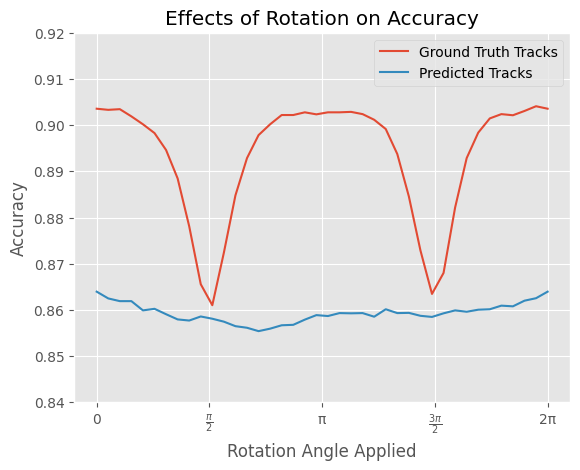

In [43]:
plt.style.use('ggplot')

plt.plot(np.linspace(0, 2*np.pi, 40), accs_gt_phi, label='Ground Truth Tracks')
plt.plot(np.linspace(0, 2*np.pi, 40), accs_pred_phi, label='Predicted Tracks')
x_ticks = np.arange(0, (2 + 1/2)*np.pi, np.pi/2)
ax = plt.gca()  # Get the current axis
ax.set_xticks(x_ticks)
ax.set_xticklabels(["0", "$\\frac{π}{2}$", "π", "$\\frac{3π}{2}$", "2π"])
plt.xlabel('Rotation Angle Applied')
plt.ylabel('Accuracy')
plt.title("Effects of Rotation on Accuracy")
plt.ylim(0.84, 0.92)
plt.legend()

In [11]:
N_BATCHES = 1
all_preds = []
all_preds_prob = []
all_correct = []
val_data.dataset.dataset.phi = 0
for z in np.linspace(-20, 20, 10):
    preds = []
    preds_prob = []
    correct = []
    val_data.dataset.dataset.z = z
    for batch in tqdm(islice(val_data, 0, N_BATCHES), total=N_BATCHES):
        mask = torch.zeros(batch.track_vector.shape[:-1])
        for i, n in enumerate(batch.n_tracks):
            mask[i, :n] = 1
            

        mask = mask.to(DEVICE)
        track_vector = batch.track_vector.to(DEVICE)
        n_batches, n_tracks = track_vector.shape[:2]
        hits = track_vector[:, :, :15].reshape(n_batches, n_tracks, 5, 3)
        
        
        is_trigger_track = batch.is_trigger_track.to(DEVICE, torch.bool)
        trigger = (batch.trigger.to(DEVICE) == 1).unsqueeze(-1)

        mask_logits = model(track_vector, mask)
        pred = mask_logits.max(dim=1)[1]
        preds.extend(pred.cpu().data.numpy())
        preds_prob.extend(nn.Softmax(dim=1)(mask_logits)[:, 1].detach().cpu().numpy().flatten())
        correct.extend(trigger.detach().cpu().numpy().flatten())
    all_correct.append(correct)
    all_preds.append(preds)
    all_preds_prob.append(preds_prob)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Effects of Z Translation on Accuracy (GT Tracks)')

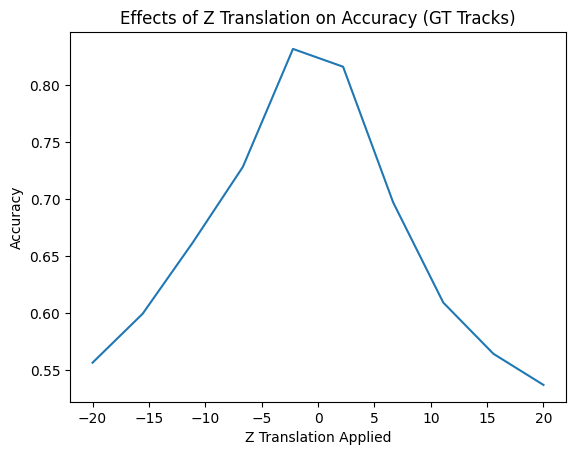

In [14]:
plt.plot(np.linspace(-20, 20, 10), accs_pred_z)
plt.xlabel('Z Translation Applied')
plt.ylabel('Accuracy')
plt.title("Effects of Z Translation on Accuracy (GT Tracks)")

In [13]:
all_preds = np.array(all_preds)
all_correct = np.array(all_correct)
accs_pred_z = np.sum(all_preds == all_correct, axis=-1)/all_correct.shape[1]

Text(0.5, 1.0, 'Effects of Z Translation on Accuracy (GT Tracks)')

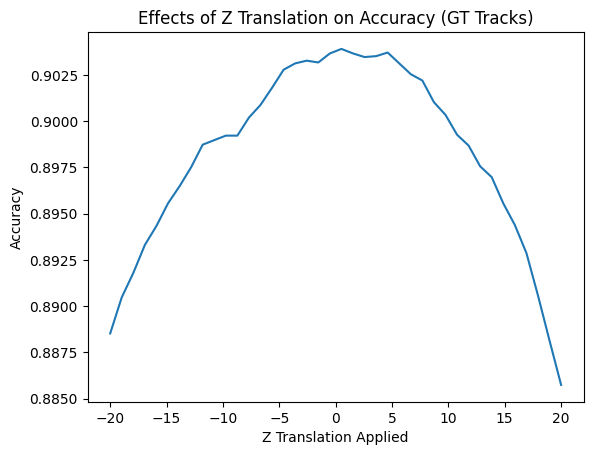

In [37]:
plt.plot(np.linspace(-20, 20, 40), accs_gt)
plt.xlabel('Z Translation Applied')
plt.ylabel('Accuracy')
plt.title("Effects of Z Translation on Accuracy (GT Tracks)")

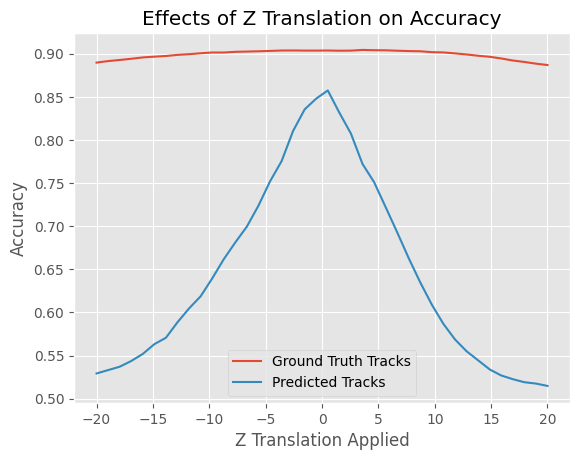

In [52]:
plt.style.use('ggplot')
plt.plot(np.linspace(-20, 20, 40), accs_gt_z, label='Ground Truth Tracks')
plt.plot(np.linspace(-20, 20, 40), accs_pred_z, label='Predicted Tracks')
plt.xlabel('Z Translation Applied')
plt.ylabel('Accuracy')
plt.title("Effects of Z Translation on Accuracy")
plt.legend()

In [34]:
accs_gt_z, accs_pred_z

(array([0.88974609, 0.89150391, 0.89277344, 0.89418945, 0.89575195,
        0.89663086, 0.89741211, 0.89868164, 0.89951172, 0.90058594,
        0.90146484, 0.90141602, 0.90224609, 0.90253906, 0.90288086,
        0.90327148, 0.90375977, 0.90380859, 0.90366211, 0.90366211,
        0.90375977, 0.90351563, 0.90361328, 0.90444336, 0.90410156,
        0.90400391, 0.90351563, 0.903125  , 0.90288086, 0.90185547,
        0.90151367, 0.90043945, 0.89916992, 0.89770508, 0.89648438,
        0.89453125, 0.8921875 , 0.89047852, 0.88852539, 0.88691406]),
 array([0.53339844, 0.53847656, 0.5449707 , 0.55209961, 0.56079102,
        0.56977539, 0.58139648, 0.59355469, 0.60717773, 0.62148437,
        0.63842773, 0.65874023, 0.67739258, 0.70102539, 0.72509766,
        0.7527832 , 0.7824707 , 0.80791016, 0.83466797, 0.85678711,
        0.8609375 , 0.8418457 , 0.81318359, 0.78413086, 0.75449219,
        0.72202148, 0.69140625, 0.6625    , 0.63354492, 0.60693359,
        0.58305664, 0.56455078, 0.55170898, 0.

# Collect Statistics on Z-Distribution

In [47]:
N_BATCHES = 400
zs = []
val_data.dataset.dataset.phi = 0
val_data.dataset.dataset.z = 0


for batch in tqdm(islice(val_data, 0, N_BATCHES), total=N_BATCHES):
    mask = torch.zeros(batch.track_vector.shape[:-1])
    for i, n in enumerate(batch.n_tracks):
        mask[i, :n] = 1

    mask = mask.to(DEVICE)
    track_vector = batch.track_vector.to(DEVICE)
    track_vector = track_vector * mask.unsqueeze(-1)
    n_batches, n_tracks = track_vector.shape[:2]
    hits = track_vector[:, :, :15].reshape(n_batches, n_tracks, 5, 3)
    good_hits = torch.any(hits != 0, dim=-1)
    zs.extend(hits[..., -1][good_hits].cpu().detach().numpy())

  0%|          | 0/400 [00:00<?, ?it/s]

In [39]:
gt_zs = np.array(zs)

In [48]:
pred_zs = np.array(zs)

Text(0.5, 1.0, 'Distribution of Z-Coordinate')

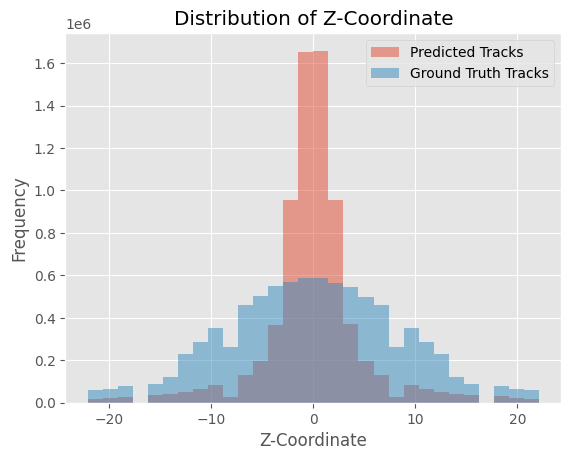

In [54]:
plt.style.use('ggplot')
plt.hist(pred_zs, bins=30, alpha=0.5, label='Predicted Tracks')
plt.hist(gt_zs, bins=30, alpha=0.5, label='Ground Truth Tracks')
plt.xlabel('Z-Coordinate')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Z-Coordinate')

In [49]:
help(plt.hist)

Help on function hist in module matplotlib.pyplot:

hist(x, bins=None, range=None, density=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, *, data=None, **kwargs)
    Compute and plot a histogram.
    
    This method uses `numpy.histogram` to bin the data in *x* and count the
    number of values in each bin, then draws the distribution either as a
    `.BarContainer` or `.Polygon`. The *bins*, *range*, *density*, and
    *weights* parameters are forwarded to `numpy.histogram`.
    
    If the data has already been binned and counted, use `~.bar` or
    `~.stairs` to plot the distribution::
    
        counts, bins = np.histogram(x)
        plt.stairs(counts, bins)
    
    Alternatively, plot pre-computed bins and counts using ``hist()`` by
    treating each bin as a single point with a weight equal to its count::
    
        plt.hist(bins[:-1], bins, weights=coun

# Track Dropping

In [67]:
N_BATCHES = 80
# No dropping
all_preds = []
all_preds_prob = []
# Drop TT
tt_preds = []
tt_preds_prob = []
# Drop NT
nt_preds = []
nt_preds_prob = []

correct = []
val_data.dataset.dataset.phi = 0
val_data.dataset.dataset.z = 0

for batch in tqdm(islice(val_data, 0, N_BATCHES), total=N_BATCHES):
    mask = torch.zeros(batch.track_vector.shape[:-1])
    nt_mask = torch.zeros(batch.track_vector.shape[:-1])
    for i, n in enumerate(batch.n_tracks):
        mask[i, :n] = 1
        nt_mask[i, :n] = 1
        n_trigger_tracks = torch.sum(batch.is_trigger_track[i].to(torch.bool))
        non_trigger_tracks = torch.where(~batch.is_trigger_track[i, :n].to(torch.bool))[0].numpy().tolist()
        #print(f'{non_trigger_tracks=}')
        random.shuffle(non_trigger_tracks)
        #print(f'{non_trigger_tracks=}')
        # We are randomly dropping the same amount of non-trigger tracks as of trigger tracks
        for j in non_trigger_tracks[:n_trigger_tracks]:
            #print(f'Setting {j} to 0')
            nt_mask[i, j] = 0
        #if n_trigger_tracks != 0:
           # print(f'{n_trigger_tracks=}\n{mask[i, :n]=}\n{nt_mask[i, :n]=}')
        

    mask = mask.to(DEVICE)
    nt_mask = nt_mask.to(DEVICE)
    track_vector = batch.track_vector.to(DEVICE)

    is_trigger_track = batch.is_trigger_track.to(DEVICE, torch.bool)
    trigger = (batch.trigger.to(DEVICE) == 1).unsqueeze(-1)

    mask_logits = model(track_vector, mask)
    pred = mask_logits.max(dim=1)[1]
    all_preds.extend(pred[trigger.flatten()].cpu().numpy())
    all_preds_prob.extend(nn.Softmax(dim=1)(mask_logits[trigger.flatten()])[:, 1].detach().cpu().numpy().flatten())
    # Drop the trigger-tracks
    tt_mask = mask * ~is_trigger_track
    mask_logits = model(track_vector, tt_mask)
    tt_preds.extend(pred[trigger.flatten()].cpu().numpy())
    tt_preds_prob.extend(nn.Softmax(dim=1)(mask_logits[trigger.flatten()])[:, 1].detach().cpu().numpy().flatten())

    mask_logits = model(track_vector, nt_mask)
    nt_preds.extend(pred[trigger.flatten()].cpu().numpy())
    nt_preds_prob.extend(nn.Softmax(dim=1)(mask_logits[trigger.flatten()])[:, 1].detach().cpu().numpy().flatten())

    
    correct.extend(trigger.detach().cpu().numpy().flatten())



  0%|          | 0/80 [00:00<?, ?it/s]

In [58]:
all_pred = np.array(all_preds_prob)
all_pred_tt = np.array(tt_preds_prob)
all_pred_nt = np.array(nt_preds_prob)

In [68]:
all_gt = np.array(all_preds_prob)
all_gt_tt = np.array(tt_preds_prob)
all_gt_nt = np.array(nt_preds_prob)

In [59]:
len(all_pred)

20534

Text(0.5, 1.0, 'Effect of Track Dropping on Trigger Probability Distribution')

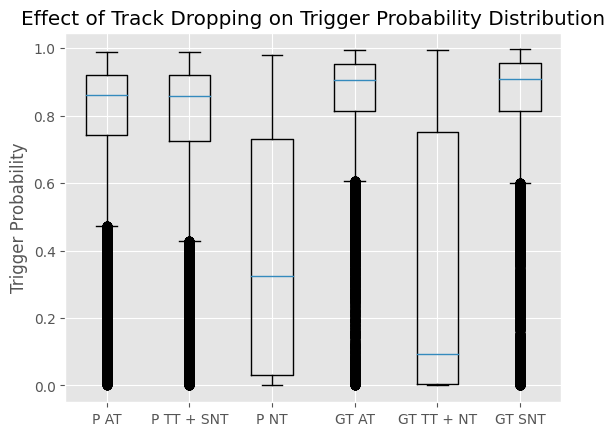

In [73]:
plt.style.use('ggplot')
plt.boxplot([all_pred, all_pred_nt, all_pred_tt, all_gt, all_gt_tt, all_gt_nt])
plt.xticks([1, 2, 3, 4, 5, 6], ['P AT', 'P TT + SNT', 'P NT', 'GT AT', 'GT TT + NT', 'GT SNT'])  # Adjust or add more labels based on your datasets
plt.ylabel('Trigger Probability')
plt.title('Effect of Track Dropping on Trigger Probability Distribution')

# Hit-Dropping

In [76]:
N_BATCHES = 80
# No dropping
pred_probs = [list() for i in range(5)]


val_data.dataset.dataset.phi = 0
val_data.dataset.dataset.z = 0

for layer_drop in range(5):
    for batch in tqdm(islice(val_data, 0, N_BATCHES), total=N_BATCHES):
        mask = torch.zeros(batch.track_vector.shape[:-1])
        for i, n in enumerate(batch.n_tracks):
            mask[i, :n] = 1


        mask = mask.to(DEVICE)
        track_vector = batch.track_vector.to(DEVICE)
        n_batches, n_tracks = track_vector.shape[:2]
        hits = track_vector[..., :15].reshape(n_batches, n_tracks, 5, 3)
        hits[:, :, layer_drop, :] = 0
        track_vector[..., :15] = hits.reshape(n_batches, n_tracks, 15)

        is_trigger_track = batch.is_trigger_track.to(DEVICE, torch.bool)
        trigger = (batch.trigger.to(DEVICE) == 1).unsqueeze(-1)

        mask_logits = model(track_vector, mask)
        pred = mask_logits.max(dim=1)[1]
        pred_probs[layer_drop].extend(nn.Softmax(dim=1)(mask_logits[trigger.flatten()])[:, 1].detach().cpu().numpy().flatten())
    


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0e34ad75b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0e244fa500>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0e441577c0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f0e244f9570>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f0e244f9210>,
 'means': []}

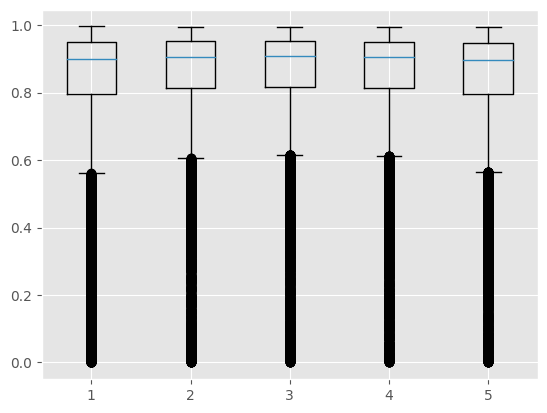

In [77]:
plt.boxplot(pred_probs)

# Noise Std

In [27]:
N_BATCHES = 40
all_preds = []
all_preds_prob = []
all_correct = []
val_data.dataset.dataset.phi = val_data.dataset.dataset.z = 0
noise_stds = np.linspace(-6, -1, 30)
#noise_stds = [-np.inf]
for noise_std in noise_stds:
    val_data.dataset.dataset.noise_std = 10**noise_std
    preds = []
    preds_prob = []
    correct = []
    for batch in tqdm(islice(val_data, 0, N_BATCHES), total=N_BATCHES):
        mask = torch.zeros(batch.track_vector.shape[:-1])
        for i, n in enumerate(batch.n_tracks):
            mask[i, :n] = 1
            

        mask = mask.to(DEVICE)
        track_vector = batch.track_vector.to(DEVICE)
        n_batches, n_tracks = track_vector.shape[:2]
        hits = track_vector[:, :, :15].reshape(n_batches, n_tracks, 5, 3)
        
        
        is_trigger_track = batch.is_trigger_track.to(DEVICE, torch.bool)
        trigger = (batch.trigger.to(DEVICE) == 1).unsqueeze(-1)

        mask_logits = model(track_vector, mask)
        pred = mask_logits.max(dim=1)[1]
        preds.extend(pred.cpu().data.numpy())
        preds_prob.extend(nn.Softmax(dim=1)(mask_logits)[:, 1].detach().cpu().numpy().flatten())
        correct.extend(trigger.detach().cpu().numpy().flatten())
    all_correct.append(correct)
    all_preds.append(preds)
    all_preds_prob.append(preds_prob)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [28]:
all_preds = np.array(all_preds)
all_correct = np.array(all_correct)
accs_gt_noise = np.sum(all_preds == all_correct, axis=-1)/all_correct.shape[1]

In [22]:
accs_gt_noise

array([0.86171875, 0.86171875, 0.86201172, 0.86123047, 0.8609375 ,
       0.86162109, 0.86054688, 0.86123047, 0.86147461, 0.85913086,
       0.85800781, 0.8550293 , 0.85263672, 0.84926758, 0.84204102,
       0.83647461, 0.82114258, 0.80473633, 0.78583984, 0.76347656,
       0.7418457 , 0.71289062, 0.68833008, 0.66591797, 0.65375977,
       0.63686523, 0.63540039, 0.63378906, 0.63691406, 0.64228516])

In [15]:
accs_pred_noise

array([0.86171875, 0.86171875, 0.86201172, 0.86123047, 0.8609375 ,
       0.86162109, 0.86054688, 0.86123047, 0.86147461, 0.85913086,
       0.85800781, 0.8550293 , 0.85263672, 0.84926758, 0.84204102,
       0.83647461, 0.82114258, 0.80473633, 0.78583984, 0.76347656,
       0.7418457 , 0.71289062, 0.68833008, 0.66591797, 0.65375977,
       0.63686523, 0.63540039, 0.63378906, 0.63691406, 0.64228516])

In [23]:
accs_gt_noise

array([0.90541992, 0.90537109, 0.90537109, 0.90541992, 0.90532227,
       0.90522461, 0.90512695, 0.90522461, 0.90493164, 0.90546875,
       0.90551758, 0.90463867, 0.90537109, 0.90395508, 0.90332031,
       0.90107422, 0.89135742, 0.87055664, 0.81494141, 0.715625  ,
       0.61269531, 0.54052734, 0.51552734, 0.50473633, 0.50180664,
       0.50058594, 0.49990234, 0.49985352, 0.49975586, 0.49951172])

In [12]:
accs_gt_noise, accs_pred_noise

NameError: name 'accs_gt_noise' is not defined

In [20]:
accs_gt_noise

array([0.86621094, 0.87011719, 0.84667969, 0.72949219, 0.66308594,
       0.64355469])

In [18]:
accs_pred_noise

array([0.86171875, 0.86171875, 0.86201172, 0.86123047, 0.8609375 ,
       0.86162109, 0.86054688, 0.86123047, 0.86147461, 0.85913086,
       0.85800781, 0.8550293 , 0.85263672, 0.84926758, 0.84204102,
       0.83647461, 0.82114258, 0.80473633, 0.78583984, 0.76347656,
       0.7418457 , 0.71289062, 0.68833008, 0.66591797, 0.65375977,
       0.63686523, 0.63540039, 0.63378906, 0.63691406, 0.64228516])

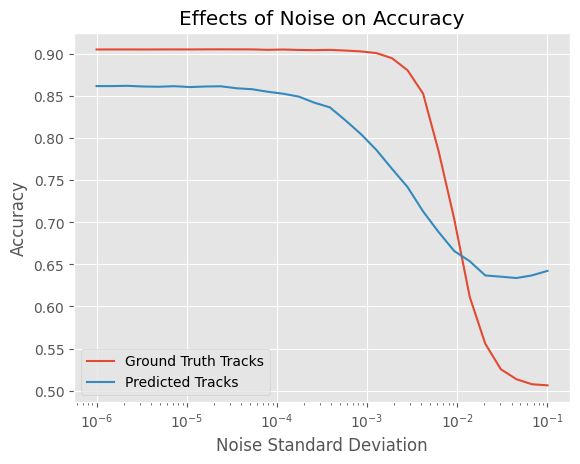

In [29]:
plt.style.use('ggplot')
plt.plot(10**noise_stds, accs_gt_noise, label='Ground Truth Tracks')
plt.plot(10**noise_stds, accs_pred_noise, label='Predicted Tracks')
plt.xlabel('Noise Standard Deviation')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.title("Effects of Noise on Accuracy")
plt.legend()